# Experimentación paper 7 Clustering y clasificación

## Librerías

In [17]:
import requests
from bs4 import BeautifulSoup


In [45]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, time, joblib
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import yfinance as yf
from ripser import ripser
from persim import PersistenceImager, plot_diagrams
import pywt
import umap.umap_ as umap
from umap import UMAP
import collections
collections.Iterable = collections.abc.Iterable
from sklearn.metrics import ConfusionMatrixDisplay

from statsmodels.tsa.stattools import acf
np.random.seed(42)


C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'UMAP' from 'umap' (C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\umap\__init__.py)

## Datos

In [22]:
START_DATE = "2025-01-01"
END_DATE = "2025-10-01"


# URL de la lista del S&P 500
url = "https://www.slickcharts.com/sp500"


# Hacer la petición con headers para evitar bloqueos
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}
response = requests.get(url, headers=headers)
response.raise_for_status()  # Raise exception for bad status codes

# Parsear el HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Encontrar la tabla
table = soup.find('table')

if table:
    # Leer la tabla con pandas
    df = pd.read_html(str(table))[0]
    
    # Extraer los tickers
    if 'Symbol' in df.columns:
        tickers = df['Symbol'].tolist()
        print(f"Found {len(tickers)} tickers")
        print("First 10 tickers:", tickers[:10])
    else:
        print("Available columns:", df.columns.tolist())

    # Extraer los pesos
    if 'Weight' in df.columns:
        weights = df['Weight'].tolist()
        print(f"Found {len(weights)} weights")
        print("First 10 weights:", weights[:10])
    else:
        print("Available columns:", df.columns.tolist())
else:
    print("No table found on the page")

# En la lista de ticker, reemplazar los "." por "-"
tickers = [ticker.replace('.', '-') for ticker in tickers]
print("Tickers after replacement:", tickers[:10])

Found 503 tickers
First 10 tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG', 'BRK.B']
Found 503 weights
First 10 weights: ['7.54%', '6.39%', '6.27%', '3.93%', '2.95%', '2.67%', '2.51%', '2.39%', '2.35%', '1.77%']
Tickers after replacement: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG', 'BRK-B']


C:\Users\a01286222\AppData\Local\Temp\ipykernel_5940\426581270.py:24: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [19]:
# -----------------------------
# Descargar precios históricos
# -----------------------------
tickers_data = yf.download(tickers, start=START_DATE, auto_adjust=True)['Close']
tickers_data = tickers_data.dropna(axis=1)  # eliminar columnas con datos faltantes

[*********************100%***********************]  503 of 503 completed


In [ ]:
#tickers y categorías
# Obtener las categorías de los tickers usando yfinance
categories = {}
for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        sector = info.get('sector', 'Unknown')
        if sector not in categories:
            categories[sector] = []
        categories[sector].append(ticker)
    except Exception as e:
        print(f"Error obteniendo sector para {ticker}: {e}")

print("Categorías encontradas:", {k: len(v) for k, v in categories.items()})


Categorías encontradas: {'Technology': 81, 'Consumer Cyclical': 55, 'Communication Services': 25, 'Financial Services': 69, 'Consumer Defensive': 37, 'Healthcare': 60, 'Energy': 22, 'Industrials': 72, 'Basic Materials': 20, 'Utilities': 31, 'Real Estate': 31}


In [21]:
display(categories)

{'Technology': ['NVDA',
  'MSFT',
  'AAPL',
  'AVGO',
  'ORCL',
  'PLTR',
  'AMD',
  'CSCO',
  'IBM',
  'CRM',
  'MU',
  'UBER',
  'ANET',
  'NOW',
  'INTU',
  'LRCX',
  'QCOM',
  'INTC',
  'AMAT',
  'TXN',
  'ACN',
  'APH',
  'PANW',
  'ADBE',
  'KLAC',
  'CRWD',
  'ADP',
  'ADI',
  'DELL',
  'CDNS',
  'SNPS',
  'MSI',
  'GLW',
  'FI',
  'ADSK',
  'FTNT',
  'TEL',
  'WDAY',
  'DDOG',
  'NXPI',
  'ROP',
  'GRMN',
  'XYZ',
  'STX',
  'MPWR',
  'PAYX',
  'WDC',
  'FICO',
  'MCHP',
  'FIS',
  'SMCI',
  'HPE',
  'CTSH',
  'KEYS',
  'TDY',
  'BR',
  'LDOS',
  'HPQ',
  'VRSN',
  'FSLR',
  'NTAP',
  'PTC',
  'TER',
  'TYL',
  'JBL',
  'ON',
  'CPAY',
  'CDW',
  'FFIV',
  'TRMB',
  'GDDY',
  'IT',
  'GEN',
  'FTV',
  'ZBRA',
  'PAYC',
  'SWKS',
  'AKAM',
  'DAY',
  'JKHY',
  'EPAM'],
 'Consumer Cyclical': ['AMZN',
  'TSLA',
  'HD',
  'MCD',
  'BKNG',
  'TJX',
  'LOW',
  'DASH',
  'NKE',
  'SBUX',
  'ORLY',
  'RCL',
  'ABNB',
  'MAR',
  'AZO',
  'HLT',
  'CMG',
  'GM',
  'ROST',
  'DHI',
  'F',

In [24]:
'''#tickers y categorías
categories = {
    "Banking": ["JPM", "WFC", "GS", "MS"],  # Categoría 1:banca
    "Tech": ["AAPL", "MSFT", "GOOGL", "AMZN"],  # Categoría 2:Tecnología
    "Energy": ["XOM", "CVX", "BP", "SLB"],  # Categoría 3:Energía
}'''

#Descargar los datos de cierre  para todos los tickers
all_tickers = [ticker for group in categories.values() for ticker in group]


df = yf.download(all_tickers, start=START_DATE, end=END_DATE, progress=False)     ####
close = df['Close'].dropna(how='all')                                                   ####

#guardamos df en un csv
#close.to_csv("stocks_experimento_3.csv")
#close = pd.read_csv("stocks_experimento_3.csv", index_col=0, parse_dates=True)
display(close.head())

#crear un DataFrame con las categorías
ticker_categories = {}
for category, tickers in categories.items():
    for ticker in tickers:
        ticker_categories[ticker] = category

#Crear un DataFrame con las categorías asignadas
category_df = pd.DataFrame.from_dict(ticker_categories, orient="index", columns=["Category"])
print(category_df)
#asegurars ede que las categorias esten alineadas coerrectamente
close = close[close.columns.intersection(category_df.index)]

#Asignar las categorías como etiquetas
labels = [ticker_categories[ticker] for ticker in close.columns]

#Mostrar los datos y etiquetas
print("Datos descargados:")
print(close.head())
print("\nEtiquetas (categorías):")
print(labels)

C:\Users\a01286222\AppData\Local\Temp\ipykernel_5940\1061747705.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(all_tickers, start=START_DATE, end=END_DATE, progress=False)     ####


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-02,132.601044,242.987427,174.627625,131.479996,111.825531,91.379997,343.909943,441.000000,208.655472,48.741325,...,27.348219,83.165047,64.710701,104.416367,114.904846,86.750000,131.643906,103.713173,383.760010,161.036179
2025-01-03,134.847000,242.499161,176.359894,135.710007,112.209984,91.400002,348.869141,430.570007,212.624191,48.576328,...,27.709734,82.688690,64.546165,104.951553,116.123764,92.160004,131.525620,103.723114,391.859985,161.729385
2025-01-06,135.582397,244.133347,175.269928,135.199997,111.431229,90.739998,346.384613,431.179993,215.220673,48.168697,...,27.846523,83.968903,63.568340,104.834785,115.786812,91.940002,128.302521,102.819618,395.329987,164.294327
2025-01-07,136.556320,241.353226,174.715210,131.289993,111.786110,92.250000,351.373413,422.630005,213.117813,47.974586,...,27.367760,81.825264,64.056282,105.817543,114.736374,87.680000,126.705780,102.392685,396.109985,161.907669
2025-01-08,136.148865,241.841461,173.712845,130.800003,112.624001,92.660004,352.694519,419.579987,217.629562,48.372513,...,27.045326,80.554970,64.788177,104.046631,114.865204,86.750000,125.907402,100.814064,397.000000,163.422867


         Category
NVDA   Technology
MSFT   Technology
AAPL   Technology
AVGO   Technology
ORCL   Technology
...           ...
UDR   Real Estate
BXP   Real Estate
HST   Real Estate
CPT   Real Estate
FRT   Real Estate

[503 rows x 1 columns]
Datos descargados:
Ticker               A        AAPL        ABBV        ABNB         ABT  \
Date                                                                     
2025-01-02  132.601044  242.987427  174.627625  131.479996  111.825531   
2025-01-03  134.847000  242.499161  176.359894  135.710007  112.209984   
2025-01-06  135.582397  244.133347  175.269928  135.199997  111.431229   
2025-01-07  136.556320  241.353226  174.715210  131.289993  111.786110   
2025-01-08  136.148865  241.841461  173.712845  130.800003  112.624001   

Ticker           ACGL         ACN        ADBE         ADI        ADM  ...  \
Date                                                                  ...   
2025-01-02  91.379997  343.909943  441.000000  208.655472  48.741325

## Preprocesamiento

In [25]:
returns = np.log(close).diff().dropna()
# ACF por ticker (usar primer lag donde acf < 1/e)
from statsmodels.tsa.stattools import acf
def choose_tau(series, threshold=0.2):
    ac = acf(series, nlags=50, fft=True)
    for k in range(1, len(ac)):
        if abs(ac[k]) < threshold:
            return k
    return 1

taus = {t: choose_tau(returns[t].dropna()) for t in returns.columns}
print("taus:", taus)

# Ventanas (no solapadas para demo rápido)
W = 100
step = W #step es igual a W para que no se entrelacen y cada uno tenga datos distintos sin repetir
def sliding_windows(series, window=W, step=step):
    x = series.values
    return np.array([x[i:i+window] for i in range(0, len(x)-window+1, step)])
Xwins = {}
for t in returns.columns:
    Xwins[t] = sliding_windows(returns[t].dropna())
    print(t, Xwins[t].shape)


taus: {'A': 1, 'AAPL': 1, 'ABBV': 1, 'ABNB': 1, 'ABT': 1, 'ACGL': 1, 'ACN': 1, 'ADBE': 1, 'ADI': 1, 'ADM': 1, 'ADP': 1, 'ADSK': 1, 'AEE': 1, 'AEP': 1, 'AES': 1, 'AFL': 1, 'AIG': 1, 'AIZ': 1, 'AJG': 1, 'AKAM': 1, 'ALB': 1, 'ALGN': 1, 'ALL': 1, 'ALLE': 1, 'AMAT': 1, 'AMCR': 1, 'AMD': 1, 'AME': 1, 'AMGN': 1, 'AMP': 1, 'AMT': 1, 'AMZN': 1, 'ANET': 1, 'AON': 1, 'AOS': 1, 'APA': 1, 'APD': 1, 'APH': 1, 'APO': 1, 'APP': 1, 'APTV': 1, 'ARE': 1, 'ATO': 1, 'AVB': 1, 'AVGO': 1, 'AVY': 1, 'AWK': 1, 'AXON': 1, 'AXP': 1, 'AZO': 1, 'BA': 1, 'BAC': 1, 'BALL': 1, 'BAX': 1, 'BBY': 1, 'BDX': 1, 'BEN': 1, 'BF-B': 1, 'BG': 1, 'BIIB': 1, 'BK': 1, 'BKNG': 1, 'BKR': 1, 'BLDR': 1, 'BLK': 1, 'BMY': 1, 'BR': 1, 'BRK-B': 1, 'BRO': 1, 'BSX': 1, 'BX': 1, 'BXP': 1, 'C': 1, 'CAG': 1, 'CAH': 1, 'CARR': 1, 'CAT': 1, 'CB': 1, 'CBOE': 1, 'CBRE': 1, 'CCI': 1, 'CCL': 1, 'CDNS': 1, 'CDW': 1, 'CEG': 1, 'CF': 1, 'CFG': 1, 'CHD': 1, 'CHRW': 1, 'CHTR': 1, 'CI': 1, 'CINF': 1, 'CL': 1, 'CLX': 1, 'CMCSA': 1, 'CME': 1, 'CMG': 1, 'CM

## Embedding

Procesando categoría: Technology
Ejemplo ventana: [ 0.04357435  0.0337561  -0.06418615 -0.00021402 -0.03043479 -0.01991603
 -0.01109499  0.03343614 -0.01979246  0.03052435  0.02240349  0.04335532
  0.00101927 -0.03174443 -0.18594604  0.08549729 -0.04187567  0.00765051
 -0.03743484 -0.02881117  0.01691423  0.05077486  0.03037575  0.0089742
  0.02832287 -0.00578136 -0.01257889  0.03115515  0.02597366  0.00395329
 -0.00122029  0.00630057 -0.04138428 -0.0313575  -0.02841661  0.03606311
 -0.08859156  0.03893255 -0.09094891  0.01677936  0.01123078 -0.05908592
  0.01899187 -0.05199885  0.01650177  0.06229469 -0.00138337  0.05134953
 -0.01774509 -0.03490313  0.01794425  0.00855756 -0.00702707  0.0310343
 -0.00594797 -0.05913433 -0.02069435 -0.01592075 -0.01183231  0.01619949
  0.0024482  -0.08128114 -0.07642289  0.03469995 -0.01381882  0.17162062
 -0.06094719  0.03075754 -0.00198519  0.01336884 -0.07119162 -0.02913114
 -0.04617746  0.02022534  0.03790136  0.03557797  0.04213292 -0.02075264
  0

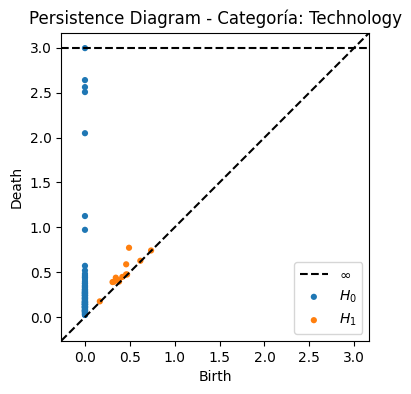

Procesando categoría: Consumer Cyclical
Ejemplo ventana: [ 1.78668653e-02  1.51397232e-02 -2.44608833e-02  9.00606529e-05
 -1.44650872e-02 -2.19476868e-03 -3.20944847e-03  2.53465614e-02
 -1.21170032e-02  2.36464162e-02  2.08920516e-02  1.84665034e-02
  1.74310215e-03 -2.42410674e-03  2.42410674e-03  1.15295564e-02
 -4.54521455e-03 -1.03030650e-02  1.28727783e-02 -1.09448343e-03
  1.93549023e-02 -2.46337423e-02  1.12001325e-02 -4.13752251e-02
  1.72623446e-02 -1.63127269e-03 -1.65916082e-02  6.27044284e-03
 -7.36307645e-03 -8.91666391e-03 -8.81972015e-05 -1.66852213e-02
 -2.86735293e-02 -1.80302354e-02  4.23004569e-04  7.25744971e-03
 -2.65207368e-02  1.68166675e-02 -3.47985960e-02 -5.96842043e-03
  2.21282200e-02 -3.74561152e-02 -7.25092293e-03 -2.39225547e-02
  1.04825602e-02  1.16315819e-02 -2.54609202e-02  2.07234733e-02
 -1.12271821e-02 -1.50301268e-02  1.40077785e-02 -3.02182797e-03
  6.44244868e-03  3.53003722e-02  1.19815219e-02 -2.25159532e-02
  1.14286442e-03 -4.38559892e-02 

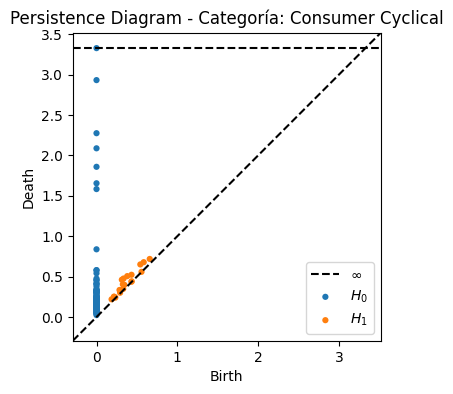

Procesando categoría: Communication Services
Ejemplo ventana: [ 0.00895442  0.04142067 -0.01972678 -0.01167191  0.00838113 -0.01230206
 -0.02341748  0.0377634  -0.00947579  0.00240199  0.00600377  0.01135527
  0.02055706  0.0171975   0.01895468  0.02166151  0.00319815  0.01541667
  0.00316811  0.01194273  0.00960301  0.00096526  0.01005037  0.00354713
  0.00402258  0.00333983  0.00772229  0.00437435  0.01107008 -0.02794331
 -0.01774508 -0.01277007 -0.01638186 -0.02281699 -0.016038    0.02434012
 -0.02321527  0.01501789 -0.01987601 -0.02324343  0.02540895 -0.04444843
 -0.0036216  -0.04523298  0.01282742  0.02260816 -0.04780284  0.02919924
 -0.00445352 -0.03797449  0.00291505  0.00331596  0.01734028  0.03720286
  0.01198261 -0.0247813  -0.01384379 -0.04382891 -0.00065899  0.01658723
 -0.00353868 -0.09385211 -0.0519053   0.02256747 -0.01129838  0.13763454
 -0.06977724 -0.00499146 -0.02249307 -0.0189178  -0.03753022 -0.00165372
 -0.03411614  0.03172035  0.03917995  0.02445497  0.02613944  

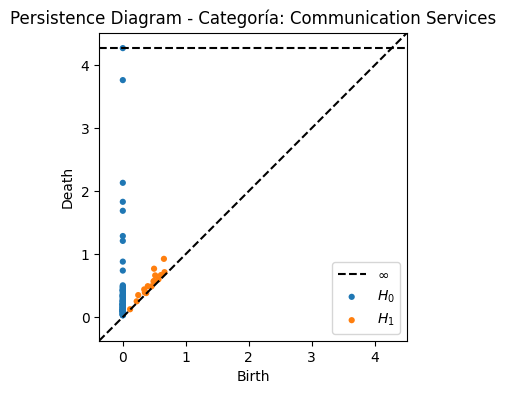

Procesando categoría: Financial Services
Ejemplo ventana: [ 5.43850178e-03 -4.75153417e-03  3.33951354e-03 -2.38741233e-03
 -2.05261375e-02  2.81985815e-03  1.36923971e-02  1.86678785e-02
  9.33447441e-03  1.10448813e-02  1.32404048e-03 -1.73509270e-02
 -1.47776543e-03  7.28051559e-03  2.45457089e-02 -1.00141858e-02
 -1.51185882e-03  6.56324248e-03 -7.82132443e-03 -8.70061224e-03
  6.17962477e-03  1.32596251e-02  7.34004071e-03 -9.43206922e-03
 -5.45117384e-03  5.17613308e-03 -1.86368177e-03  1.83995849e-02
 -1.87483162e-03  6.71236396e-03  1.96563589e-03 -4.08049960e-03
 -6.37143269e-03  4.02854899e-02  2.80492624e-03 -1.15101101e-02
  1.66785885e-02  2.24759780e-02 -7.32495487e-03 -2.82739506e-02
  5.30999013e-03 -1.32485650e-03 -4.46923869e-03  2.98173116e-03
 -1.71139338e-03 -6.24875413e-04  1.66172202e-02  2.03176756e-02
  1.62107506e-02  2.48539656e-04  4.06331062e-03  6.56541436e-03
 -1.29827599e-02  7.52084677e-03  5.72669119e-03  8.17273829e-03
  2.45380043e-03 -1.54787963e-02

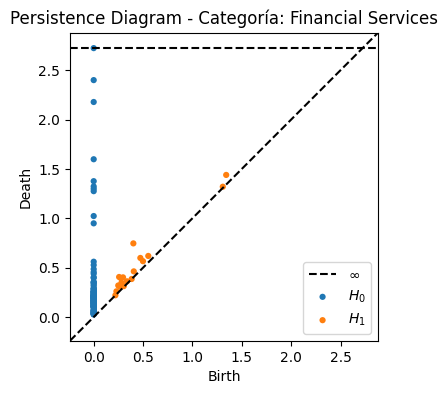

Procesando categoría: Consumer Defensive
Ejemplo ventana: [ 0.00862939  0.00713457 -0.00680422  0.01084289  0.01298714 -0.01593262
 -0.00811768  0.00603969 -0.00043796  0.00698539  0.01232306  0.0016103
  0.00620178  0.01007598  0.02747891 -0.00113005  0.00215611  0.01172585
 -0.00497935  0.01396073  0.01228116  0.01663173  0.00379917 -0.016667
  0.0173474  -0.00438197  0.01106377  0.01380263 -0.00966107 -0.00250221
  0.00211772 -0.06751733 -0.02531515 -0.01178051  0.04202127 -0.01536993
  0.00611437  0.018629   -0.01039758 -0.02721397  0.01057888 -0.01405971
 -0.03133974 -0.04345125 -0.00433636 -0.02595146 -0.00824992  0.01000884
  0.02442126 -0.02161312  0.00860866 -0.00604163  0.00472164  0.01740968
 -0.03170079  0.00529506  0.00491694 -0.00562132  0.03053327  0.01177681
  0.01041496 -0.02824719 -0.04776499  0.00766372 -0.02463591  0.09120027
  0.01120929  0.02388213  0.02058404 -0.00805517 -0.03003032  0.02201706
 -0.00872706  0.02606143  0.001159    0.00922438 -0.00785637  0.00136

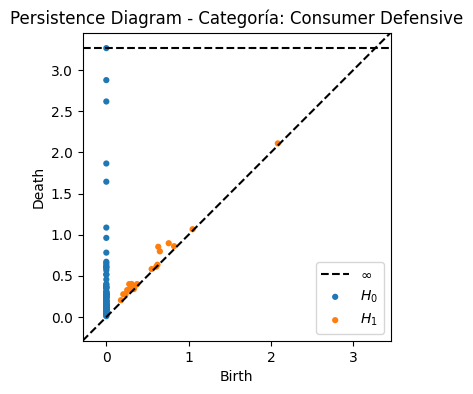

Procesando categoría: Healthcare
Ejemplo ventana: [ 0.00501263 -0.02182258  0.01064759  0.01785353  0.01597913 -0.00303008
 -0.0681933   0.00245371  0.01443837 -0.04299126  0.02265658  0.01554502
  0.01659934  0.02424067  0.02856659 -0.00394255 -0.0011311   0.02353678
 -0.01486879 -0.00080185  0.01911461  0.01931419  0.03292473  0.00908117
 -0.01079455 -0.00447552  0.00917161 -0.00127225 -0.03043448  0.01519881
  0.01142536  0.00697643  0.00064116  0.00879737  0.02288115  0.01454233
 -0.01082332  0.01694645  0.0098253  -0.02027475  0.02027475 -0.01841052
 -0.04846259 -0.0468738  -0.0068932  -0.00267326 -0.02489795  0.01464921
  0.01377107 -0.0027318   0.01747542  0.00662077 -0.00595196  0.03210902
 -0.01461666 -0.0304828  -0.00617562  0.00102184  0.00412518 -0.02535786
  0.01600327 -0.0362508  -0.06665209 -0.01981001  0.00346216  0.03712727
 -0.04449349  0.01582621  0.02951595  0.00374452 -0.02986645  0.13361981
 -0.02646753  0.01157062  0.00226925  0.03589172  0.02844938 -0.00823018
 

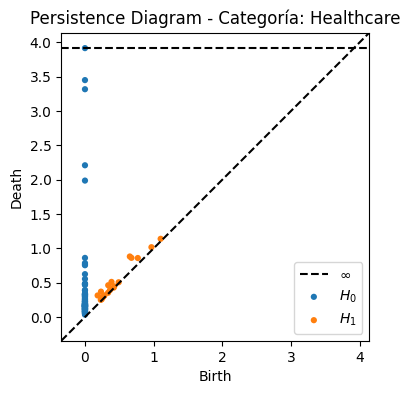

Procesando categoría: Energy
Ejemplo ventana: [ 0.00511242 -0.00111321  0.00933068 -0.01687715 -0.00365401  0.02548444
  0.00392675  0.01618265 -0.00170533  0.00894296 -0.00759652 -0.01755694
  0.00564457 -0.01361933  0.01380083 -0.01952309  0.00581433  0.00824778
 -0.02532482  0.00243076  0.02644713 -0.0007278  -0.01328409  0.00423344
  0.01892175  0.0062881  -0.03054862  0.00723974  0.00101673  0.0174013
  0.00145167  0.01529492 -0.01176532  0.00522607 -0.01393682 -0.00246368
  0.00628395  0.01065572 -0.03259223 -0.00204371 -0.01972075  0.02046444
  0.01292479  0.02518028 -0.02389686 -0.00027498 -0.00422399  0.0292899
  0.01648529 -0.00105545  0.01545553  0.00423672 -0.00345726  0.00259407
  0.00679888  0.01430666 -0.00321811 -0.00135808  0.01014115  0.00092458
 -0.0031131  -0.05401577 -0.07467606 -0.01350837 -0.02130567  0.04870987
 -0.05708055  0.03161729  0.00242091 -0.0028088   0.0105168   0.02586473
 -0.01479282  0.02761706 -0.00862435  0.01166674 -0.00055244  0.00055244
 -0.002

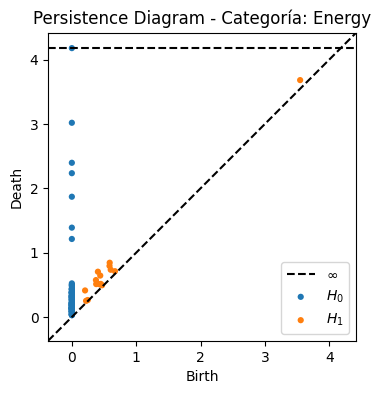

Procesando categoría: Industrials
Ejemplo ventana: [ 0.01979224  0.00284543 -0.00081212  0.00336031 -0.00696494 -0.00069921
  0.03036717  0.019208   -0.00305517  0.01715479  0.02511268  0.0045762
  0.06395432 -0.02037552 -0.01170726 -0.00015435  0.02373501  0.03197943
 -0.00977673  0.00264905 -0.0095007   0.01180078  0.00720829 -0.00379245
 -0.00029237  0.01739013  0.00391905 -0.00612441 -0.000432    0.0086531
  0.00199728 -0.0083962  -0.04362259 -0.00562038  0.00281414  0.01167455
 -0.00089328  0.02718013 -0.02455238 -0.01592128  0.0185915  -0.03237018
 -0.01128505 -0.00710566 -0.00208418  0.01696361 -0.01331913  0.02408146
  0.02465425 -0.00615668  0.02352706 -0.00800986  0.00098031  0.02944509
  0.00899712 -0.02269464 -0.00721107 -0.02957633  0.0013498   0.01802308
 -0.01992331 -0.06269482 -0.11761649  0.00532124  0.0099089   0.10046583
 -0.03124069  0.00088105  0.02355488 -0.00177577 -0.01749474 -0.00362399
 -0.01910423  0.05895095  0.02350841  0.01907548  0.00515363  0.01217182
 -

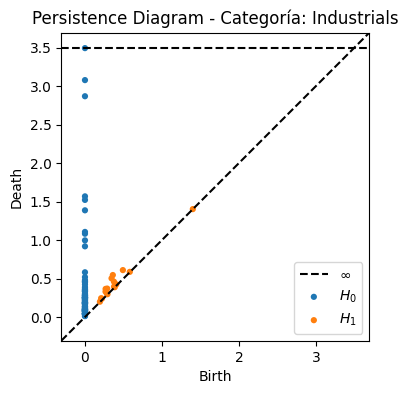

Procesando categoría: Basic Materials
Ejemplo ventana: [-0.00161903 -0.00142775  0.00492834  0.01212044 -0.01405029  0.01742542
  0.01380924  0.00161362  0.01048265  0.00808307  0.01470781  0.00031635
 -0.00400715 -0.00359061  0.00054621 -0.00909708  0.00643146  0.01822145
 -0.00058267  0.01797164  0.00129801 -0.00242145  0.01526747 -0.01229641
  0.01268697 -0.0002604  -0.0047427   0.0054153  -0.00882307  0.01913732
 -0.00810427 -0.00036799 -0.00847925  0.00115651  0.01935221 -0.01278755
 -0.00275541  0.01460131 -0.01033036 -0.00194893  0.01484538 -0.00447341
  0.00558332 -0.01441749 -0.01744343 -0.00640716  0.00795198  0.00492978
  0.01050443  0.00086867 -0.00208594 -0.00435968  0.00126628  0.00165678
 -0.00357866  0.00866279  0.00712623 -0.01216682  0.01412306  0.00310909
  0.0056574  -0.0053791  -0.06467267 -0.02801695 -0.02986432  0.07600535
 -0.03210384  0.02277737  0.00946103  0.01101459 -0.00662986  0.00917674
 -0.01846097  0.02395315 -0.01417798  0.00294071 -0.00251692 -0.00089

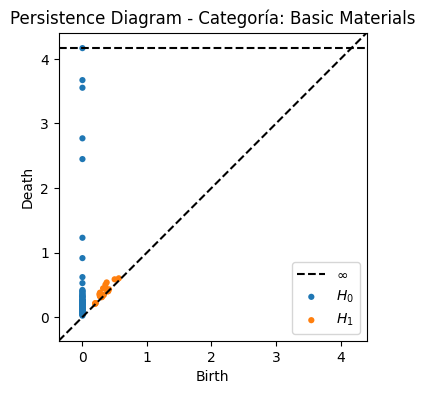

Procesando categoría: Utilities
Ejemplo ventana: [ 0.00529241 -0.01047256 -0.01143527  0.00326049 -0.0475317  -0.00625264
  0.01511821  0.01908684  0.02957713 -0.0085837   0.00127109 -0.03387733
  0.01074675  0.05069354  0.01363722 -0.04558522  0.00494948  0.00576686
  0.00363997 -0.00715234 -0.01631821 -0.01006496  0.00101108 -0.01454139
  0.02072989  0.00899805 -0.01504217 -0.00986372 -0.00790291  0.00644421
  0.00814184  0.01551753  0.02032261 -0.01095672  0.00675672 -0.00379504
 -0.02322224  0.01952828  0.02045358 -0.0108095  -0.00523585 -0.00669095
  0.0394898   0.04470854 -0.02836604 -0.0151074  -0.00260908  0.01121158
 -0.01977271 -0.01974734 -0.0028327   0.00917767 -0.00380213 -0.01149356
 -0.021348    0.01648396  0.00429301  0.00597948  0.00622617  0.00042314
 -0.00622341  0.0232796  -0.07526022 -0.0280385  -0.01470955  0.05271171
 -0.01280743 -0.01373293  0.0281668  -0.00044333 -0.03030991  0.01015534
 -0.0248886   0.02985296  0.00940937 -0.01377056 -0.00392645  0.00151204
  

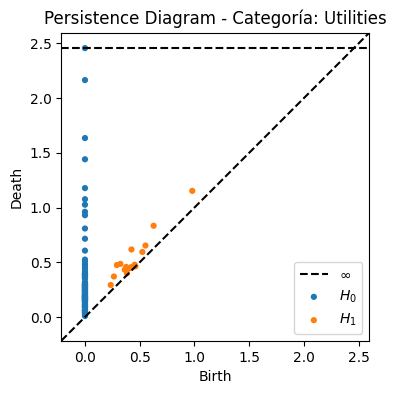

Procesando categoría: Real Estate
Ejemplo ventana: [ 0.0087811  -0.01416761  0.00153041  0.01786907 -0.01353195  0.00750494
  0.00910576 -0.00220947  0.01676364  0.00472745  0.0329296  -0.01903246
  0.00827677  0.03353601  0.0123547  -0.00943393 -0.0163191   0.01653774
 -0.00511581  0.02817509 -0.01088685  0.02369797  0.00140552  0.00140355
  0.00364019  0.00202429  0.02138765  0.03316412 -0.00975437  0.0055193
 -0.00725449  0.00406635 -0.0116429   0.01376938  0.01173323 -0.0072093
  0.00575852  0.01304793  0.02158811 -0.01905079  0.00615405 -0.03871203
 -0.01025595 -0.00851358  0.00742792  0.00061094 -0.01016135  0.01327763
  0.02286961 -0.00856494 -0.00810108 -0.00586547 -0.00930675  0.02240609
 -0.01120773  0.01127452  0.000467    0.02307737 -0.00136965  0.00611656
 -0.00696552 -0.00425517 -0.06183495 -0.03176444 -0.01685465  0.03597776
  0.00225889  0.00604625  0.02026011  0.00684518 -0.00657035  0.01119835
 -0.02488783  0.02475201  0.00271283  0.00067708 -0.00536114  0.01412136
  

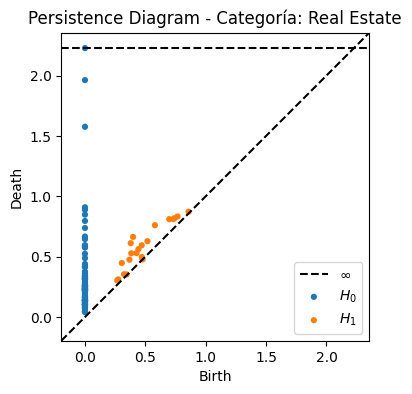

In [60]:
def time_delay_embedding(window, d=3, tau=0):
    W = len(window)
    m = W - (d-1)*tau
    emb = np.vstack([window[i:i+m] for i in range(0, d*tau, tau)]).T
    return emb

def embed(points,d=2,tau=1):
    auxembed=[]
    for i in range(0,len(points)-d+1):
        aux=[points[i+j] for j in range(d)]
        auxembed.append(aux)
    auxembed=np.array(auxembed)
    return auxembed

#Estas dos funciones don diferentes opciones para basicamente lo mismo
# la segunda es una version qu evi en mi clase de topología



# Procesar por categorías
for category, tickers_in_category in categories.items():
    print(f"Procesando categoría: {category}")
    
    # Combinar las ventanas de todos los tickers en esta categoría
    category_windows = []
    for ticker in tickers_in_category:
        category_windows.extend(Xwins[ticker])  # Agregar las ventanas del ticker actual
    
    # Tomar la primera ventana de la categoría para el ejemplo
    w = category_windows[0]
    tau0 = taus[tickers_in_category[0]]  # Usar el tau del primer ticker en la categoría
    print("Ejemplo ventana:", w, "tau0:", tau0)
    
    # Hacer el embedding
    emb = time_delay_embedding(w, d=2, tau=tau0)
    
    #diagrama de persistencia
    dgms = ripser(StandardScaler().fit_transform(emb), maxdim=1)['dgms']
    plt.figure(figsize=(6, 4))  
    plot_diagrams(dgms)
    plt.title(f"Persistence Diagram - Categoría: {category}")
    plt.show()


## Compute tda features

Procesando categoría: Technology


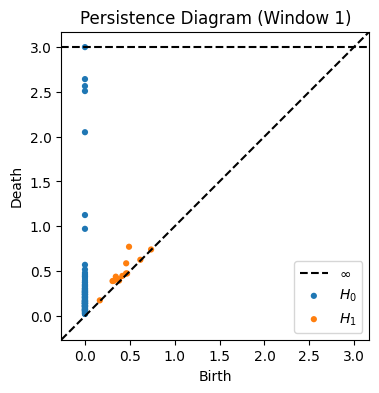

Procesando categoría: Consumer Cyclical


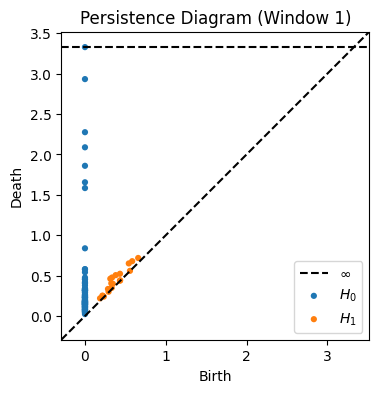

Procesando categoría: Communication Services


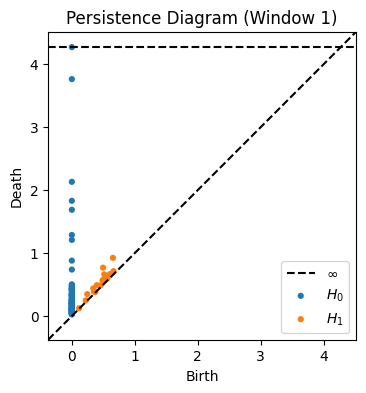

Procesando categoría: Financial Services


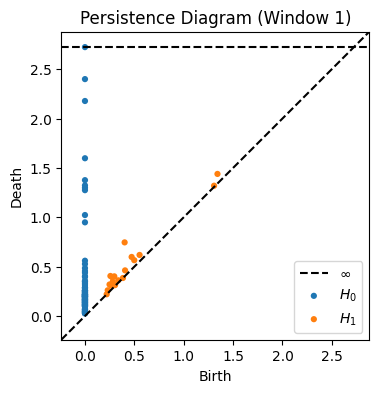

Procesando categoría: Consumer Defensive


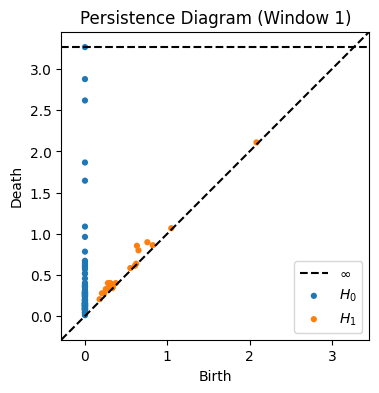

Procesando categoría: Healthcare


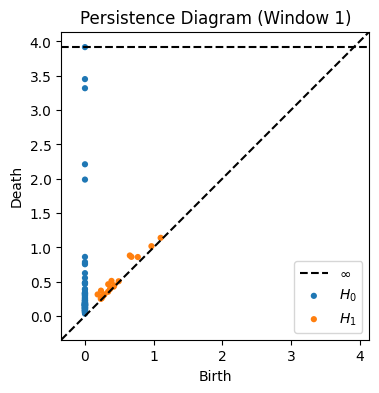

Procesando categoría: Energy


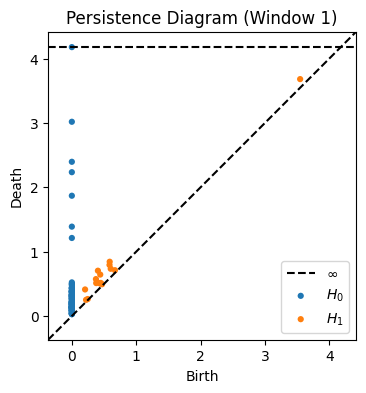

Procesando categoría: Industrials


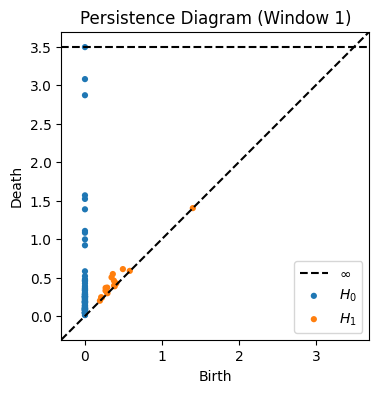

Procesando categoría: Basic Materials


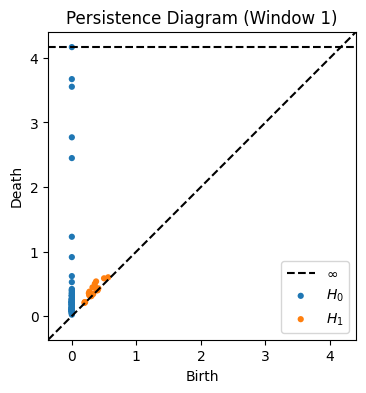

Procesando categoría: Utilities


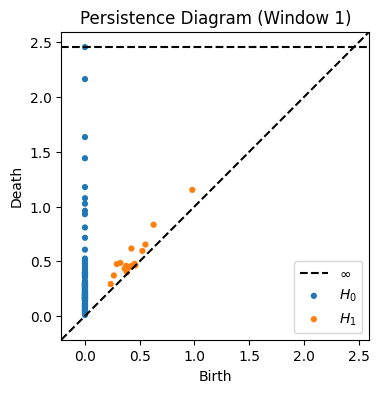

Procesando categoría: Real Estate


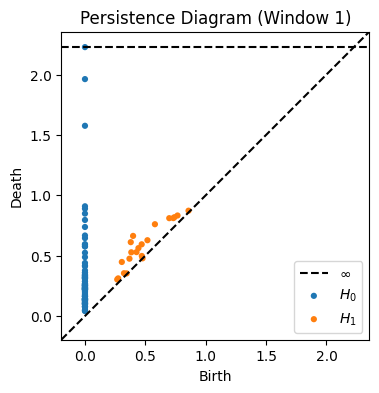

X_imgs shape: (503, 819)


In [61]:
# convertimos ventanas a diagrams y luego a persistence images
def windows_to_diagrams(Xwins_for_category, d=3, tau=1, maxdim=1):
    diagrams = []
    for i,w in enumerate(Xwins_for_category):
        emb = time_delay_embedding(w, d=d, tau=tau) # embed o time_delay_embedding
        emb_s = StandardScaler().fit_transform(emb)
        dgms = ripser(emb_s, maxdim=maxdim)['dgms']
        # Concatenate H0 and H1, and filter out infinite values
        finite_dgms = [dgm[np.isfinite(dgm).all(axis=1)] for dgm in dgms]
        diagrams.append(np.vstack(finite_dgms))
        #graficar algunos de los persistence diagrams 
        if i < 1:  # Graficar solo la primera ventana por categoria, esto cambialo a como quieras, lo dejo así para ahorrar espacio
            fig = plt.figure(figsize=(6, 4))
            ax = fig.add_subplot(111)
            plot_diagrams(dgms, ax=ax, show=False)
            ax.set_title(f"Persistence Diagram (Window {i+1})")
            plt.show()

    return diagrams





# Ejemplo: hacerlo para todos los tickers (usa menos ventanas para demo rápido)
all_diagrams = []
labels = []
'''for t in tickers:
    # tomar sólo primeras N windows si hay muchas
    nmax = 30
    diags = windows_to_diagrams(Xwins[t][:nmax], d=2, tau=taus[t], maxdim=1)
    all_diagrams.extend(diags)
    labels.extend([t]*len(diags))
'''

for category, tickers_in_category in categories.items():
    print(f"Procesando categoría: {category}")
    
    # Combinar las ventanas de todos los tickers en esta categoría
    category_windows = []
    for ticker in tickers_in_category:
        category_windows.extend(Xwins[ticker])  # Agregar las ventanas del ticker actual
    
    # Tomar sólo las primeras N ventanas si hay muchas
    nmax = 30
    category_windows = category_windows[:]
    
    # Calcular diagramas de persistencia para la categoría
    tau0 = taus[tickers_in_category[0]]  # Usar el tau del primer ticker en la categoría
    diags = windows_to_diagrams(category_windows, d=2, tau=tau0, maxdim=1)
    all_diagrams.extend(diags)
    labels.extend([category] * len(diags))  # Usar la categoría como etiqueta



# PersistenceImager (fit con todos)
pim = PersistenceImager(pixel_size=0.2, birth_range=(0,1))
pim.fit(all_diagrams)
X_imgs = np.array([pim.transform(dgm).ravel() for dgm in all_diagrams])
print("X_imgs shape:", X_imgs.shape)


## Train RF 

Accuracy RF-TDA: 0.2871287128712871
                        precision    recall  f1-score   support

       Basic Materials       0.00      0.00      0.00         4
Communication Services       0.00      0.00      0.00         5
     Consumer Cyclical       0.25      0.09      0.13        11
    Consumer Defensive       0.40      0.25      0.31         8
                Energy       0.00      0.00      0.00         4
    Financial Services       0.38      0.36      0.37        14
            Healthcare       0.27      0.33      0.30        12
           Industrials       0.23      0.40      0.29        15
           Real Estate       0.00      0.00      0.00         6
            Technology       0.29      0.62      0.39        16
             Utilities       0.33      0.17      0.22         6

              accuracy                           0.29       101
             macro avg       0.20      0.20      0.18       101
          weighted avg       0.24      0.29      0.24       101



C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

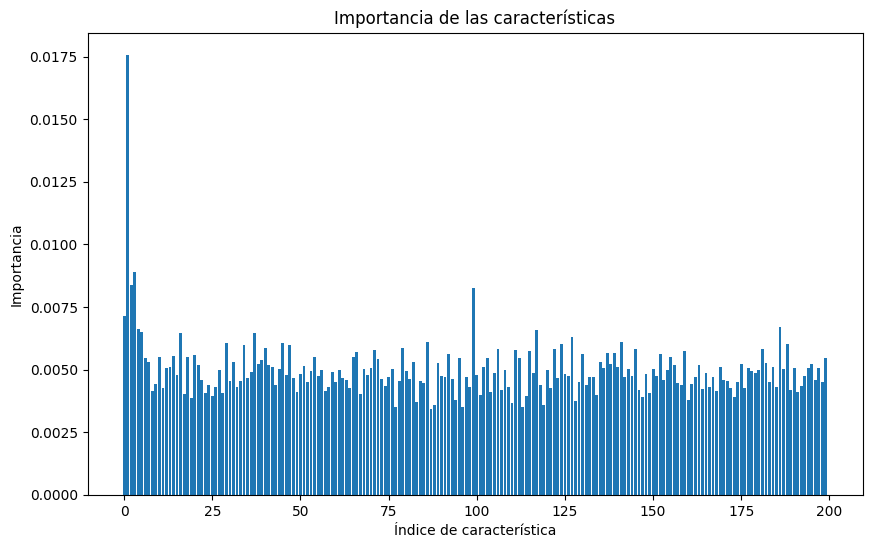

In [62]:
# Codificar las categorías como etiquetas
le = LabelEncoder(); y = le.fit_transform(labels)

X = X_imgs
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# opcional: reducción de dimensión si X es muy grande
from sklearn.decomposition import TruncatedSVD
if X.shape[1] > 250:
    svd = TruncatedSVD(n_components=200, random_state=42)
    X_train = svd.fit_transform(X_train)
    X_test = svd.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy RF-TDA:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Mostrar la importancia de las características
importances = rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title("Importancia de las características")
plt.xlabel("Índice de característica")
plt.ylabel("Importancia")
plt.show()





[[ 0  0  0  0  0  1  1  1  0  1  0]
 [ 0  0  0  0  0  0  0  1  0  4  0]
 [ 0  0  1  0  0  1  2  3  0  4  0]
 [ 0  0  0  2  0  0  0  2  0  4  0]
 [ 0  0  0  0  0  1  0  1  0  2  0]
 [ 0  0  1  0  0  5  2  2  0  4  0]
 [ 0  0  0  1  0  2  4  1  0  2  2]
 [ 0  0  1  0  0  0  4  6  0  4  0]
 [ 0  0  1  0  0  1  1  3  0  0  0]
 [ 0  0  0  1  0  1  0  4  0 10  0]
 [ 0  0  0  1  0  1  1  2  0  0  1]]


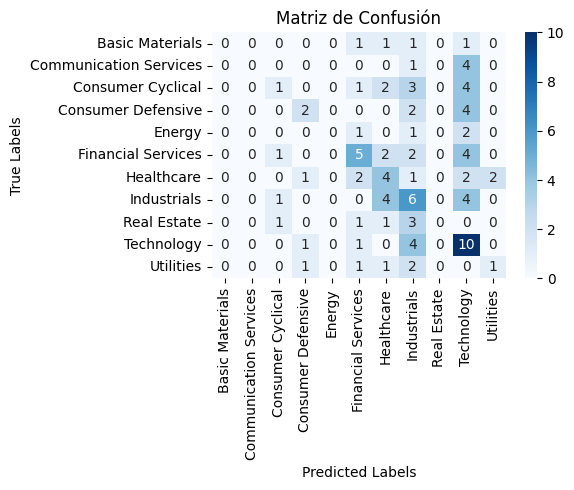

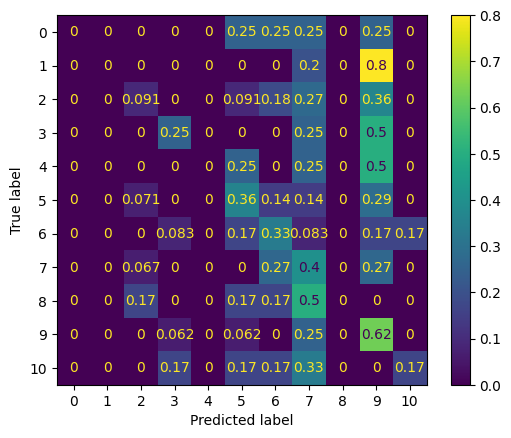

In [63]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')

In [64]:
print("Shape of X_imgs:", X_imgs.shape)

Shape of X_imgs: (503, 819)


In [65]:
pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [66]:
# =======================================================
# 🚀 MEJORAS PARA GENERACIÓN DE DATOS DE ENTRENAMIENTO
# =======================================================

print("📊 Análisis de datos antes de mejoras:")
print(f"Shape original X_imgs: {X_imgs.shape}")
print(f"Número de muestras por categoría: {pd.Series(labels).value_counts()}")
print(f"Distribución de clases: {pd.Series(labels).value_counts(normalize=True)}")

# 1. BALANCEO DE CLASES CON ESTRATEGIAS AVANZADAS
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

# Codificar labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

print(f"\n🎯 Distribución original de clases:")
for i, class_name in enumerate(le.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {class_name}: {count} muestras ({count/len(y_encoded)*100:.1f}%)")

# Estrategia 1: SMOTE para balanceo inteligente
print("\n🔄 Aplicando SMOTE para balancear clases...")
smote = SMOTE(random_state=42, k_neighbors=3)
X_balanced_smote, y_balanced_smote = smote.fit_resample(X_imgs, y_encoded)

print(f"Después de SMOTE: {X_balanced_smote.shape}")
print(f"Distribución balanceada: {Counter(y_balanced_smote)}")

# Estrategia 2: Combinación SMOTETomek (más conservadora)
print("\n🔄 Aplicando SMOTETomek...")
smote_tomek = SMOTETomek(random_state=42)
X_balanced_hybrid, y_balanced_hybrid = smote_tomek.fit_resample(X_imgs, y_encoded)

print(f"Después de SMOTETomek: {X_balanced_hybrid.shape}")
print(f"Distribución híbrida: {Counter(y_balanced_hybrid)}")

# 2. AUMENTACIÓN DE DATOS ESPECÍFICA PARA TDA
def augment_persistence_images(X, factor=2):
    """Aumenta datos añadiendo ruido gaussiano pequeño a persistence images"""
    X_augmented = []
    
    for _ in range(factor):
        # Añadir ruido muy pequeño (no queremos cambiar mucho la topología)
        noise = np.random.normal(0, 0.01, X.shape)
        X_noisy = X + noise
        # Asegurar que no haya valores negativos (las persistence images son no-negativas)
        X_noisy = np.maximum(X_noisy, 0)
        X_augmented.append(X_noisy)
    
    return np.vstack(X_augmented)

print("\n🎨 Aplicando aumentación específica para TDA...")
X_augmented = augment_persistence_images(X_imgs, factor=2)
y_augmented = np.tile(y_encoded, 3)  # Original + 2 aumentadas

print(f"Después de aumentación: {X_augmented.shape}")
print(f"Labels aumentadas: {len(y_augmented)}")

# 3. SELECCIÓN DE CARACTERÍSTICAS MEJORADA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import ExtraTreesClassifier

print("\n🎯 Selección de características avanzada...")

# Método 1: Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k=min(150, X_imgs.shape[1]))
X_selected_mi = selector_mi.fit_transform(X_imgs, y_encoded)

# Método 2: RFE con ExtraTrees
et_selector = ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rfe = RFE(estimator=et_selector, n_features_to_select=min(100, X_imgs.shape[1]))
X_selected_rfe = rfe.fit_transform(X_imgs, y_encoded)

print(f"Features seleccionadas (MI): {X_selected_mi.shape[1]}")
print(f"Features seleccionadas (RFE): {X_selected_rfe.shape[1]}")

# 4. VALIDACIÓN CRUZADA ESTRATIFICADA
from sklearn.model_selection import StratifiedKFold
print(f"\n✅ Datos mejorados preparados para entrenamiento!")

📊 Análisis de datos antes de mejoras:
Shape original X_imgs: (503, 819)
Número de muestras por categoría: Technology                81
Industrials               72
Financial Services        69
Healthcare                60
Consumer Cyclical         55
Consumer Defensive        37
Real Estate               31
Utilities                 31
Communication Services    25
Energy                    22
Basic Materials           20
Name: count, dtype: int64
Distribución de clases: Technology                0.161034
Industrials               0.143141
Financial Services        0.137177
Healthcare                0.119284
Consumer Cyclical         0.109344
Consumer Defensive        0.073559
Real Estate               0.061630
Utilities                 0.061630
Communication Services    0.049702
Energy                    0.043738
Basic Materials           0.039761
Name: proportion, dtype: float64

🎯 Distribución original de clases:
  Basic Materials: 20 muestras (4.0%)
  Communication Services: 25 mues

In [67]:
# =======================================================
# 🌲 RANDOM FOREST OPTIMIZADO CON MEJORES PRÁCTICAS
# =======================================================

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
import time

# 1. BÚSQUEDA DE HIPERPARÁMETROS INTELIGENTE
print("🔍 Optimización de hiperparámetros con RandomizedSearchCV...")

# Parámetros para buscar (más eficiente que GridSearch)
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Usar datos balanceados para búsqueda
X_search = X_balanced_smote
y_search = y_balanced_smote

# Split estratificado
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    X_search, y_search, test_size=0.2, stratify=y_search, random_state=42
)

# RandomizedSearchCV (más rápido que GridSearchCV)
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=20,  # Número de combinaciones a probar
    cv=3,  # 3-fold CV para ser más rápido
    scoring='f1_macro',  # Mejor para clases desbalanceadas
    n_jobs=-1,
    random_state=42,
    verbose=1
)

start_time = time.time()
rf_random.fit(X_train_opt, y_train_opt)
search_time = time.time() - start_time

print(f"⏱️  Tiempo de búsqueda: {search_time:.2f} segundos")
print(f"🏆 Mejores parámetros encontrados:")
for param, value in rf_random.best_params_.items():
    print(f"  {param}: {value}")

print(f"📊 Mejor score CV: {rf_random.best_score_:.4f}")

# 2. MODELO OPTIMIZADO
best_rf = rf_random.best_estimator_

# 3. ENSEMBLE DE MODELOS (Voting Classifier)
print("\n🤝 Creando ensemble de modelos...")

# Random Forest optimizado
rf_opt = RandomForestClassifier(**rf_random.best_params_, random_state=42, n_jobs=-1)

# Extra Trees (más diversidad)
et_opt = ExtraTreesClassifier(
    n_estimators=200, 
    max_depth=20,
    min_samples_split=5,
    random_state=42, 
    n_jobs=-1,
    class_weight='balanced'
)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_opt),
        ('et', et_opt)
    ],
    voting='soft'  # Usa probabilidades en lugar de votos duros
)

# 4. PIPELINE COMPLETO CON PREPROCESSING
print("\n🔧 Creando pipeline completo...")

# Pipeline con escalado robusto
pipeline_rf = Pipeline([
    ('scaler', RobustScaler()),  # Más robusto a outliers que StandardScaler
    ('rf', rf_opt)
])

pipeline_voting = Pipeline([
    ('scaler', RobustScaler()),
    ('voting', voting_clf)
])

# 5. ENTRENAMIENTO Y EVALUACIÓN COMPARATIVA
models = {
    'RF_Optimized': pipeline_rf,
    'Ensemble_Voting': pipeline_voting,
    'RF_Original': Pipeline([('scaler', StandardScaler()), 
                            ('rf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
}

results = {}

print("\n🏃‍♂️ Entrenando y evaluando modelos...")
for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Entrenamiento
    start_time = time.time()
    model.fit(X_train_opt, y_train_opt)
    train_time = time.time() - start_time
    
    # Predicción
    y_pred = model.predict(X_test_opt)
    
    # Métricas
    accuracy = accuracy_score(y_test_opt, y_pred)
    cv_scores = cross_val_score(model, X_train_opt, y_train_opt, cv=3, scoring='f1_macro')
    
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_time': train_time
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"CV F1-macro: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"Tiempo entrenamiento: {train_time:.2f}s")

# 6. RESUMEN DE RESULTADOS
print("\n📈 RESUMEN DE RESULTADOS:")
print("=" * 60)
for name, metrics in results.items():
    print(f"{name:15} | Acc: {metrics['accuracy']:.4f} | CV: {metrics['cv_mean']:.4f}±{metrics['cv_std']:.3f} | Time: {metrics['train_time']:.1f}s")

# Seleccionar el mejor modelo
best_model_name = max(results.keys(), key=lambda x: results[x]['cv_mean'])
best_model = models[best_model_name]

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"📊 CV Score: {results[best_model_name]['cv_mean']:.4f}")

# Guardar el mejor modelo para uso posterior
import joblib
joblib.dump(best_model, 'best_tda_model.pkl')
print(f"💾 Modelo guardado como 'best_tda_model.pkl'")

🔍 Optimización de hiperparámetros con RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
⏱️  Tiempo de búsqueda: 41.21 segundos
🏆 Mejores parámetros encontrados:
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: None
  class_weight: balanced
  bootstrap: True
📊 Mejor score CV: 0.4597

🤝 Creando ensemble de modelos...

🔧 Creando pipeline completo...

🏃‍♂️ Entrenando y evaluando modelos...

--- RF_Optimized ---
Accuracy: 0.5642
CV F1-macro: 0.4597 (±0.0065)
Tiempo entrenamiento: 0.27s

--- Ensemble_Voting ---
Accuracy: 0.5754
CV F1-macro: 0.4670 (±0.0151)
Tiempo entrenamiento: 0.40s

--- RF_Original ---
Accuracy: 0.5587
CV F1-macro: 0.4654 (±0.0186)
Tiempo entrenamiento: 0.22s

📈 RESUMEN DE RESULTADOS:
RF_Optimized    | Acc: 0.5642 | CV: 0.4597±0.007 | Time: 0.3s
Ensemble_Voting | Acc: 0.5754 | CV: 0.4670±0.015 | Time: 0.4s
RF_Original     | Acc: 0.5587 | CV: 0.4654±0.019 | Time: 0.2s

🏆 MEJOR MODELO: Ensemb

📊 Análisis detallado del mejor modelo...


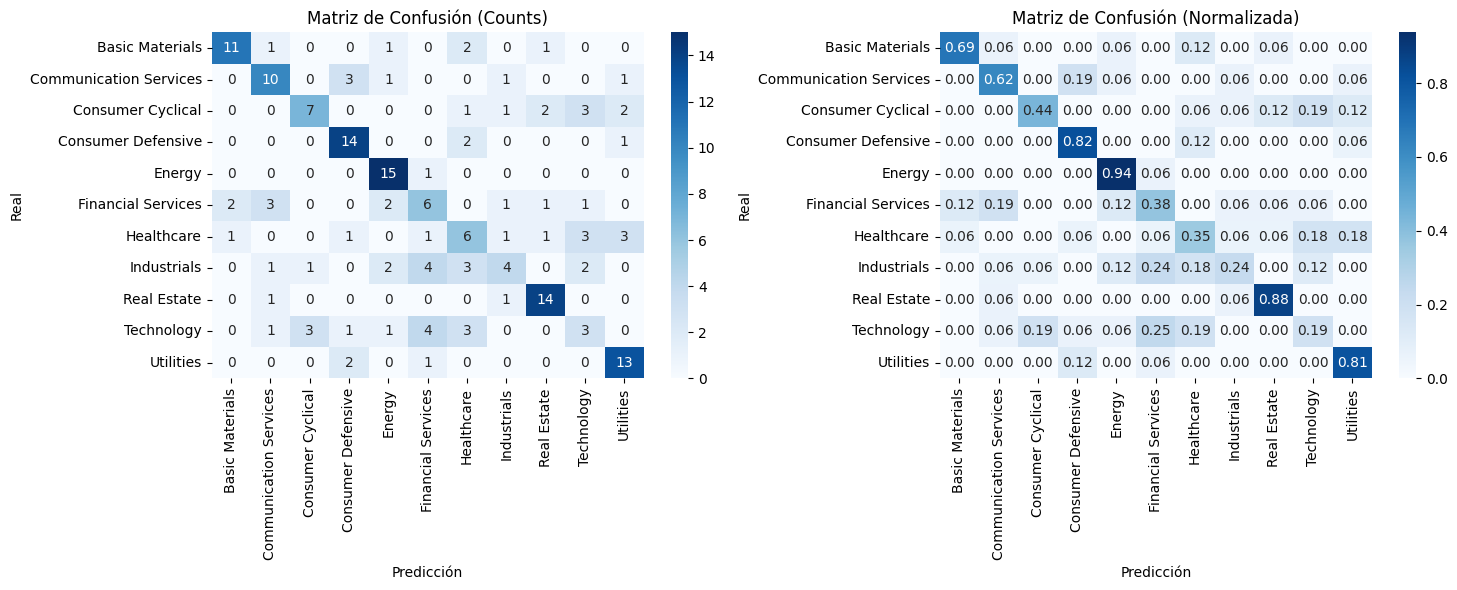

\n📋 REPORTE DE CLASIFICACIÓN DETALLADO:
                        precision    recall  f1-score   support

       Basic Materials       0.79      0.69      0.73        16
Communication Services       0.59      0.62      0.61        16
     Consumer Cyclical       0.64      0.44      0.52        16
    Consumer Defensive       0.67      0.82      0.74        17
                Energy       0.68      0.94      0.79        16
    Financial Services       0.35      0.38      0.36        16
            Healthcare       0.35      0.35      0.35        17
           Industrials       0.44      0.24      0.31        17
           Real Estate       0.74      0.88      0.80        16
            Technology       0.25      0.19      0.21        16
             Utilities       0.65      0.81      0.72        16

              accuracy                           0.58       179
             macro avg       0.56      0.58      0.56       179
          weighted avg       0.56      0.58      0.56       17

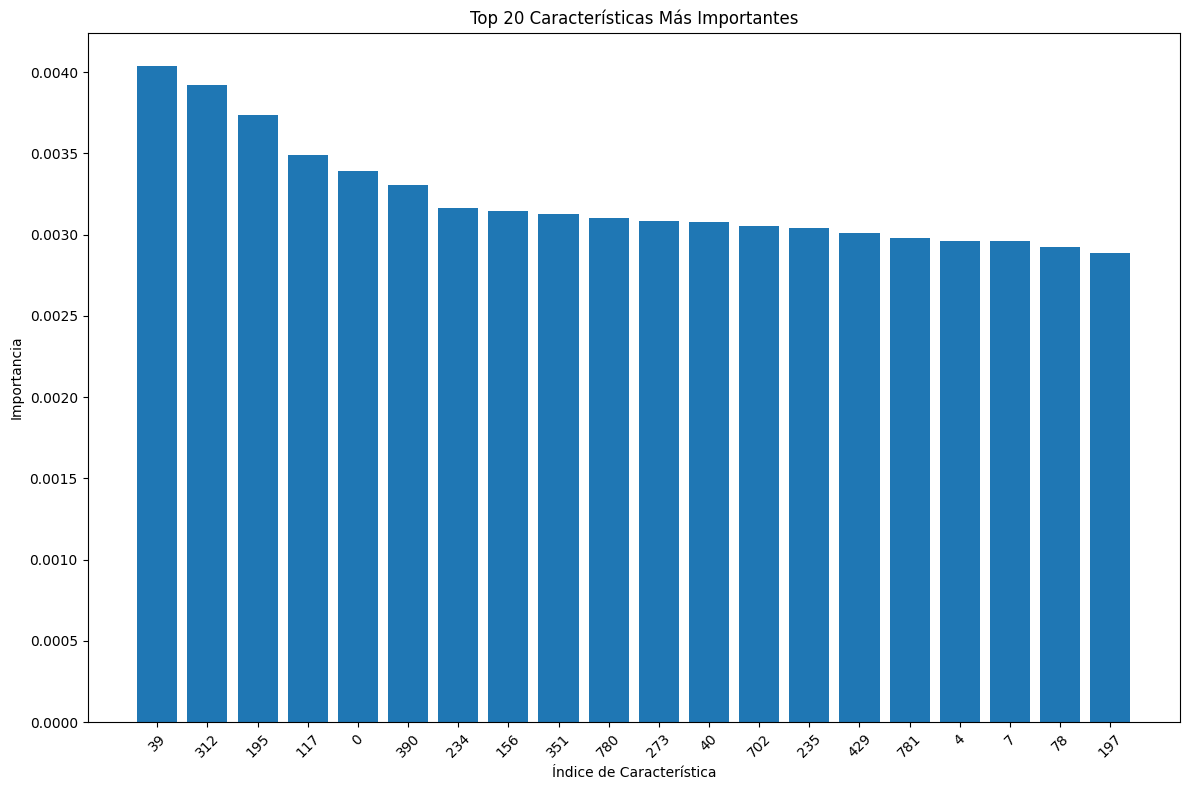

📊 Top 5 características más importantes:
  Feature 39: 0.0040
  Feature 312: 0.0039
  Feature 195: 0.0037
  Feature 117: 0.0035
  Feature 0: 0.0034
\n🎲 ANÁLISIS DE CONFIANZA DE PREDICCIONES:


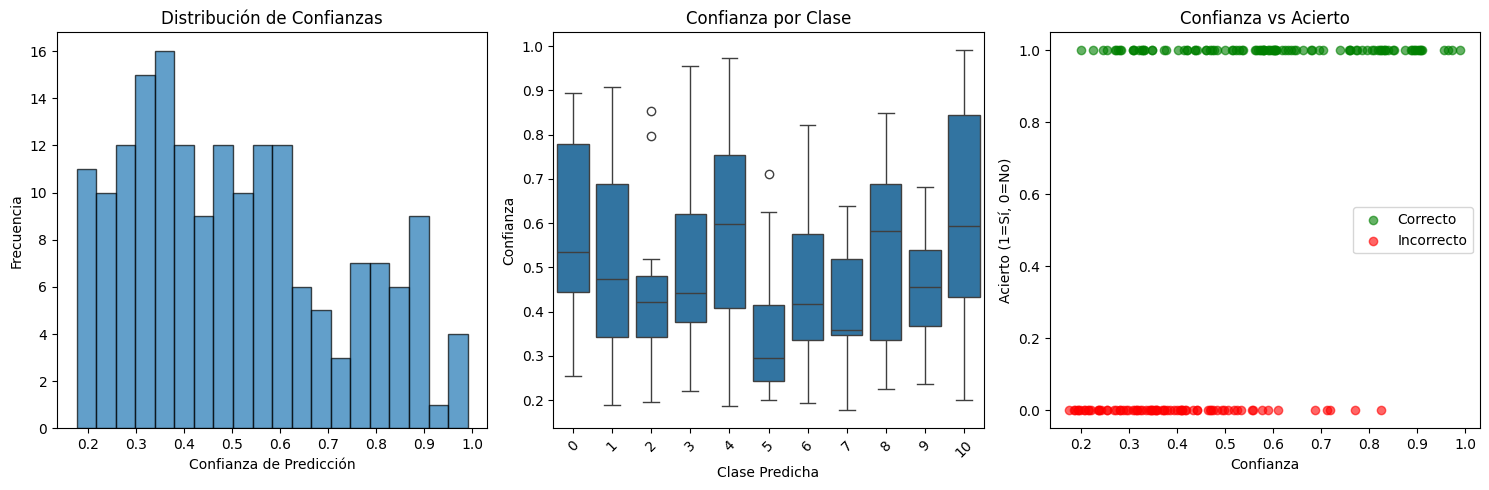

Confianza promedio: 0.508
Confianza mínima: 0.177
Confianza máxima: 0.990
\n⚠️  97 predicciones con confianza < 0.5
Clases de baja confianza: 5     14
3     12
6     12
1     10
2      8
8      8
9      7
4      7
0      7
10     7
7      5
Name: count, dtype: int64
\n📈 ANÁLISIS DE CURVAS DE APRENDIZAJE:


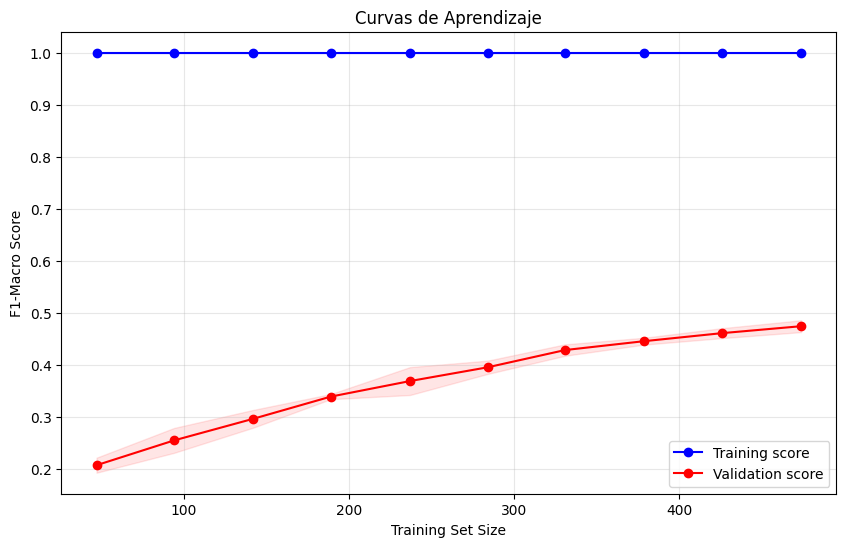

✅ Análisis completo terminado!


In [68]:
# =======================================================
# 📊 ANÁLISIS AVANZADO Y INTERPRETABILIDAD
# =======================================================

# 1. MATRIZ DE CONFUSIÓN MEJORADA
print("📊 Análisis detallado del mejor modelo...")

# Usar el mejor modelo
y_pred_best = best_model.predict(X_test_opt)
y_pred_proba = best_model.predict_proba(X_test_opt)

# Matriz de confusión con más detalles
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz de confusión absoluta
cm = confusion_matrix(y_test_opt, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title('Matriz de Confusión (Counts)')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Matriz de confusión normalizada
cm_norm = confusion_matrix(y_test_opt, y_pred_best, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title('Matriz de Confusión (Normalizada)')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\\n📋 REPORTE DE CLASIFICACIÓN DETALLADO:")
print("=" * 60)
print(classification_report(y_test_opt, y_pred_best, target_names=le.classes_))

# 2. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
print("\\n🎯 ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS:")

# Extraer el modelo Random Forest del pipeline
if 'rf' in best_model.named_steps:
    rf_model = best_model.named_steps['rf']
elif 'voting' in best_model.named_steps:
    # Para voting classifier, usar el RF interno
    rf_model = best_model.named_steps['voting'].estimators_[0]

if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    
    # Top 20 características más importantes
    indices = np.argsort(importances)[::-1][:20]
    
    plt.figure(figsize=(12, 8))
    plt.title('Top 20 Características Más Importantes')
    plt.bar(range(20), importances[indices[:20]])
    plt.xlabel('Índice de Característica')
    plt.ylabel('Importancia')
    plt.xticks(range(20), indices[:20], rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Top 5 características más importantes:")
    for i in range(5):
        idx = indices[i]
        print(f"  Feature {idx}: {importances[idx]:.4f}")

# 3. ANÁLISIS DE CONFIANZA DE PREDICCIONES
print("\\n🎲 ANÁLISIS DE CONFIANZA DE PREDICCIONES:")

# Calcular confianza (máxima probabilidad)
confidences = np.max(y_pred_proba, axis=1)

plt.figure(figsize=(15, 5))

# Subplot 1: Distribución de confianzas
plt.subplot(1, 3, 1)
plt.hist(confidences, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Confianza de Predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Confianzas')

# Subplot 2: Confianza por clase predicha
plt.subplot(1, 3, 2)
conf_by_class = pd.DataFrame({'confidence': confidences, 'predicted': y_pred_best})
sns.boxplot(data=conf_by_class, x='predicted', y='confidence')
plt.xlabel('Clase Predicha')
plt.ylabel('Confianza')
plt.title('Confianza por Clase')
plt.xticks(rotation=45)

# Subplot 3: Confianza vs Acierto
plt.subplot(1, 3, 3)
correct = (y_test_opt == y_pred_best)
plt.scatter(confidences[correct], [1]*sum(correct), alpha=0.6, label='Correcto', color='green')
plt.scatter(confidences[~correct], [0]*sum(~correct), alpha=0.6, label='Incorrecto', color='red')
plt.xlabel('Confianza')
plt.ylabel('Acierto (1=Sí, 0=No)')
plt.title('Confianza vs Acierto')
plt.legend()

plt.tight_layout()
plt.show()

# Estadísticas de confianza
print(f"Confianza promedio: {confidences.mean():.3f}")
print(f"Confianza mínima: {confidences.min():.3f}")
print(f"Confianza máxima: {confidences.max():.3f}")

# Identificar predicciones de baja confianza
low_conf_threshold = 0.5
low_conf_mask = confidences < low_conf_threshold
if low_conf_mask.any():
    print(f"\\n⚠️  {sum(low_conf_mask)} predicciones con confianza < {low_conf_threshold}")
    print("Clases de baja confianza:", pd.Series(y_pred_best[low_conf_mask]).value_counts())

# 4. CURVAS DE APRENDIZAJE
print("\\n📈 ANÁLISIS DE CURVAS DE APRENDIZAJE:")

from sklearn.model_selection import learning_curve

# Calcular curvas de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_opt, y_train_opt, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3, scoring='f1_macro', n_jobs=-1
)

# Plotear curvas
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training score', color='blue')
plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1, color='blue')

plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation score', color='red')
plt.fill_between(train_sizes, val_scores.mean(axis=1) - val_scores.std(axis=1),
                 val_scores.mean(axis=1) + val_scores.std(axis=1), alpha=0.1, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('F1-Macro Score')
plt.title('Curvas de Aprendizaje')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("✅ Análisis completo terminado!")

## Baseline DWT RF

In [69]:


def dwt_feats(window, wavelet='db4', level=3):
    
    #Extraer características de una ventana usando la Transformada Wavelet Discreta (DWT).
    coeffs = pywt.wavedec(window, wavelet, level=level)
    feats = np.hstack([np.array([c.mean(), c.std()]) for c in coeffs])
    return feats

#Construir X_dwt alineado a las categorías
X_dwt = []
for category, tickers_in_category in categories.items():
    for ticker in tickers_in_category:
        for w in Xwins[ticker][:30]:  # Tomar las primeras 30 ventanas por ticker
            X_dwt.append(dwt_feats(w))
X_dwt = np.array(X_dwt)

#ajustar dimensiones y entrenar
X_train, X_test, y_train, y_test = train_test_split(X_dwt, y, test_size=0.2, stratify=y, random_state=42)
rf2 = RandomForestClassifier(n_estimators=90, random_state=42, n_jobs=-1)
rf2.fit(X_train, y_train)

#Evaluar
y_pred = rf2.predict(X_test)
print("Accuracy DWT+RF:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy DWT+RF: 0.4158415841584158
                        precision    recall  f1-score   support

       Basic Materials       0.00      0.00      0.00         4
Communication Services       0.67      0.40      0.50         5
     Consumer Cyclical       0.17      0.18      0.17        11
    Consumer Defensive       0.62      0.62      0.62         8
                Energy       0.67      0.50      0.57         4
    Financial Services       0.57      0.57      0.57        14
            Healthcare       0.42      0.42      0.42        12
           Industrials       0.31      0.33      0.32        15
           Real Estate       0.33      0.17      0.22         6
            Technology       0.39      0.56      0.46        16
             Utilities       0.43      0.50      0.46         6

              accuracy                           0.42       101
             macro avg       0.42      0.39      0.39       101
          weighted avg       0.41      0.42      0.41       101



C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\a01286222\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

[[0 0 1 0 0 0 1 2 0 0 0]
 [0 2 0 0 0 0 0 0 0 2 1]
 [0 0 2 2 0 0 1 1 0 4 1]
 [0 0 0 5 0 0 1 0 1 1 0]
 [0 0 0 0 2 0 0 0 0 2 0]
 [0 0 1 0 0 8 0 2 0 1 2]
 [0 0 4 0 1 2 5 0 0 0 0]
 [0 0 2 0 0 1 2 5 1 4 0]
 [0 0 0 1 0 2 1 1 1 0 0]
 [0 1 2 0 0 0 1 3 0 9 0]
 [0 0 0 0 0 1 0 2 0 0 3]]


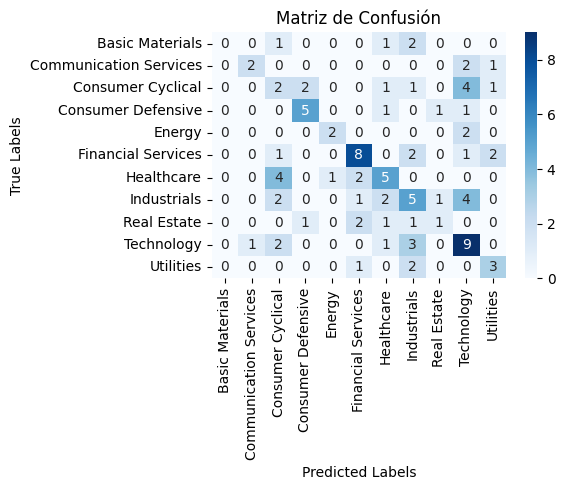

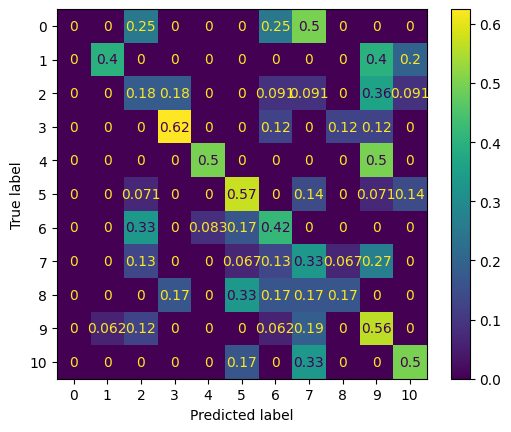

In [70]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')